In [1]:
from visual_behavior.data_access import loading
import visual_behavior.utilities as vbu
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from multiprocessing import Pool
import seaborn as sns
from scipy import stats
import itertools
import visual_behavior.database as db

import allensdk.brain_observatory.behavior.behavior_project_cache as bpc

from visual_behavior.visualization import utils as vis_utils

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/session_api_utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## get release data summary table

In [3]:
# choose a location on your file system to cache NWB files as they are loaded:
my_cache_dir = '//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/visual_behavior_production_analysis/'

# bc = bpc.VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=my_cache_dir)
bc = bpc.VisualBehaviorOphysProjectCache.from_lims(data_release_date='2021-03-25')
          
behavior_session_table = bc.get_behavior_session_table().sort_values(by = ['mouse_id', 'date_of_acquisition'])

# NOTE: behavior_session_id 944971315 was an OPHYS_0 session that was run out of order. Dropping it to avoid messing up time-to-stage statistics
behavior_session_table.drop(index = 944971315, inplace=True)

## calculate training day for each mouse

In [4]:
behavior_session_table['mouse_id'] = behavior_session_table['mouse_id'].astype(int)
behavior_session_table['mouse_id_shifted'] = behavior_session_table['mouse_id'].shift().fillna(0).astype(int)

In [5]:
behavior_session_table['training_day'] = 0
for idx, row in behavior_session_table.iterrows():
    if row['mouse_id'] != row['mouse_id_shifted']:
        training_day = 0
    else:
        training_day += 1
        
    behavior_session_table.at[idx, 'training_day'] = training_day

## make a simplified session_type column

In [6]:
np.sort(behavior_session_table['session_type'].unique())

array(['OPHYS_0_images_A_habituation', 'OPHYS_0_images_B_habituation',
       'OPHYS_1_images_A', 'OPHYS_1_images_B', 'OPHYS_2_images_A_passive',
       'OPHYS_2_images_B_passive', 'OPHYS_3_images_A', 'OPHYS_3_images_B',
       'OPHYS_4_images_A', 'OPHYS_4_images_B', 'OPHYS_5_images_A_passive',
       'OPHYS_5_images_B_passive', 'OPHYS_6_images_A', 'OPHYS_6_images_B',
       'TRAINING_0_gratings_autorewards_15min', 'TRAINING_1_gratings',
       'TRAINING_2_gratings_flashed', 'TRAINING_3_images_A_10uL_reward',
       'TRAINING_3_images_B_10uL_reward',
       'TRAINING_4_images_A_handoff_lapsed',
       'TRAINING_4_images_A_handoff_ready',
       'TRAINING_4_images_A_training', 'TRAINING_4_images_B_training',
       'TRAINING_5_images_A_epilogue',
       'TRAINING_5_images_A_handoff_lapsed',
       'TRAINING_5_images_A_handoff_ready',
       'TRAINING_5_images_B_epilogue',
       'TRAINING_5_images_B_handoff_lapsed',
       'TRAINING_5_images_B_handoff_ready'], dtype=object)

In [7]:
behavior_session_table['session_type_simple'] = behavior_session_table['session_type'].map(lambda st: st.split('_')[0] + '_' + st.split('_')[1])

In [8]:
np.sort(behavior_session_table['session_type_simple'].unique())

array(['OPHYS_0', 'OPHYS_1', 'OPHYS_2', 'OPHYS_3', 'OPHYS_4', 'OPHYS_5',
       'OPHYS_6', 'TRAINING_0', 'TRAINING_1', 'TRAINING_2', 'TRAINING_3',
       'TRAINING_4', 'TRAINING_5'], dtype=object)

## make a column that assigns an ordered number to each phase (eg. training_0 becomes 0.0, training_1 becomes 0.1, ophys_0 becomes 1.0, etc)

In [9]:
name_map = {'TRAINING': '0', 'OPHYS': '1'}
behavior_session_table['session_type_ordered'] = behavior_session_table['session_type_simple'].map(lambda sts: float(name_map[sts.split('_')[0]] + '.' + sts.split('_')[1]))

## and another column that assigns a single category to each

In [10]:
stage_categories = np.sort(behavior_session_table['session_type_ordered'].unique())
session_type_category_map = {sto: v for v, sto in zip(range(len(stage_categories)), stage_categories)}
session_type_category_map

{0.0: 0,
 0.1: 1,
 0.2: 2,
 0.3: 3,
 0.4: 4,
 0.5: 5,
 1.0: 6,
 1.1: 7,
 1.2: 8,
 1.3: 9,
 1.4: 10,
 1.5: 11,
 1.6: 12}

In [11]:
behavior_session_table['session_type_category'] = behavior_session_table['session_type_ordered'].map(lambda sto: session_type_category_map[sto])

## get the max training days for each mouse to facilitate sorting

In [12]:
behavior_session_table['max_training_days'] = behavior_session_table['mouse_id'].map(lambda mouse_id: behavior_session_table.query('mouse_id == {}'.format(mouse_id))['training_day'].max())

## make a pivot table with training days as columns, session category as values. Then merge in cre_line and max_training_days to facilitate sorting

In [13]:
training_matrix = pd.pivot(
    behavior_session_table.sort_values(by = ['mouse_id', 'max_training_days']),
    index = 'mouse_id',
    columns = 'training_day',
    values = 'session_type_category'
)

training_matrix = training_matrix.merge(
    behavior_session_table.reset_index()[['mouse_id','cre_line','max_training_days']].set_index('mouse_id'),
    left_index = True,
    right_index = True,
    how='left'
).drop_duplicates()



## make a color palette

In [14]:
training_palette = sns.color_palette("gray", 6)

palette_map = {
    'TRAINING_0': training_palette[0], 
    'TRAINING_1': training_palette[1], 
    'TRAINING_2': training_palette[2],
    'TRAINING_3': training_palette[3],
    'TRAINING_4': training_palette[4], 
    'TRAINING_5': training_palette[5],
    'OPHYS_0': vis_utils.get_session_type_color_map()['OPHYS_0_images_A_habituation']/255, 
    'OPHYS_1': vis_utils.get_session_type_color_map()['OPHYS_1_images_A']/255, 
    'OPHYS_2': vis_utils.get_session_type_color_map()['OPHYS_2_images_A_passive']/255,
    'OPHYS_3': vis_utils.get_session_type_color_map()['OPHYS_3_images_A']/255, 
    'OPHYS_4': vis_utils.get_session_type_color_map()['OPHYS_4_images_B']/255,
    'OPHYS_5': vis_utils.get_session_type_color_map()['OPHYS_5_images_B_passive']/255,
    'OPHYS_6': vis_utils.get_session_type_color_map()['OPHYS_6_images_B']/255, 
}
palette = [palette_map[st] for st in palette_map.keys()]
palette

[(0.1411764705882353, 0.1411764705882353, 0.1411764705882353),
 (0.28627450980392155, 0.28627450980392155, 0.28627450980392155),
 (0.42745098039215684, 0.42745098039215684, 0.42745098039215684),
 (0.5725490196078431, 0.5725490196078431, 0.5725490196078431),
 (0.7137254901960784, 0.7137254901960784, 0.7137254901960784),
 (0.8588235294117647, 0.8588235294117647, 0.8588235294117647),
 array([0.93254902, 0.81254902, 0.8172549 ]),
 array([0.6627451 , 0.0627451 , 0.08627451]),
 array([0.95686275, 0.30588235, 0.21960784]),
 array([0.98823529, 0.68627451, 0.57647059]),
 array([0.04313725, 0.33333333, 0.62352941]),
 array([0.3254902 , 0.61568627, 0.8       ]),
 array([0.72941176, 0.83921569, 0.91764706])]

## make a heatmap

<IPython.core.display.Javascript object>


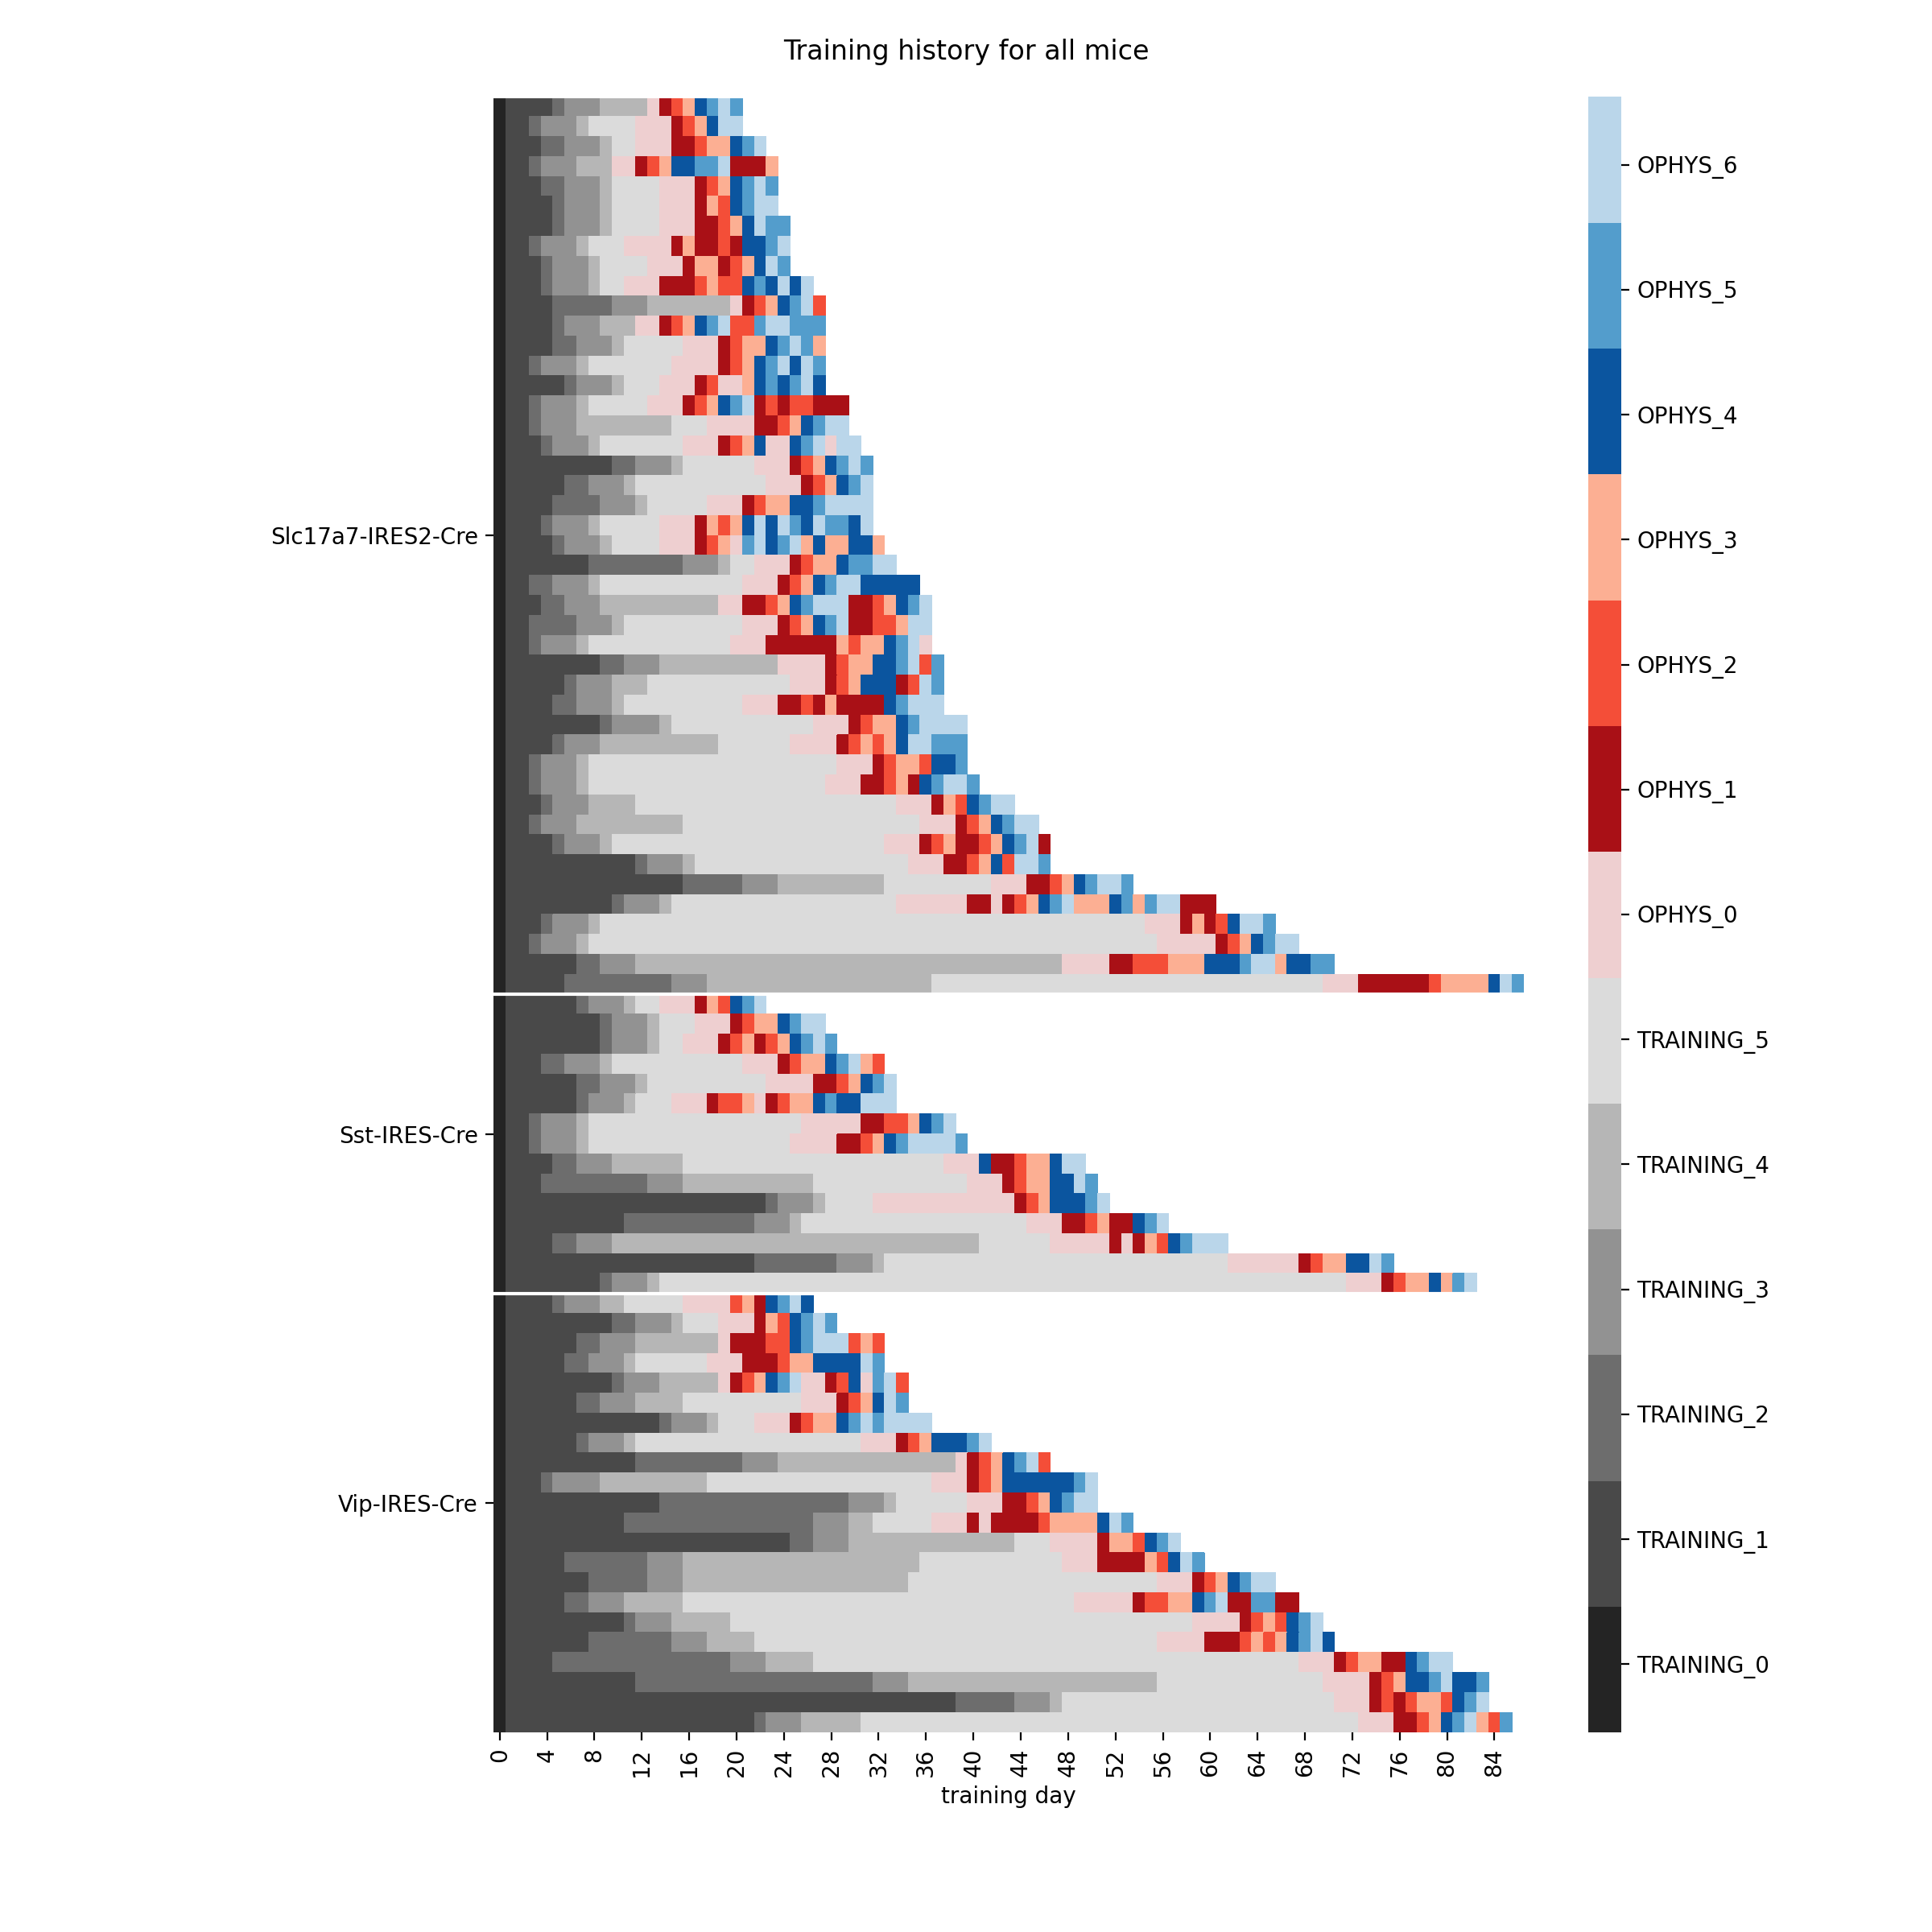

Text(0.5, 0.98, 'Training history for all mice')

In [15]:
fig, ax = plt.subplots(figsize = (6,6))

# build a sorted training matrix
sorted_training_matrix = (
    training_matrix
    .sort_values(by = ['cre_line','max_training_days'])
).reset_index()

# build a dictionary with indices where cre_line changes
prev_cre_line = None
index_dict = {}
for idx, row in sorted_training_matrix.iterrows():
    if row['cre_line'] != prev_cre_line:
        index_dict[row['cre_line']] = {}
        index_dict[row['cre_line']]['first_index'] = idx
        prev_cre_line = row['cre_line']
    else:
        index_dict[row['cre_line']]['last_index'] = idx
        

hm = sns.heatmap(
    sorted_training_matrix.drop(columns = ['mouse_id', 'cre_line', 'max_training_days']),
    cmap = palette,
    cbar_kws={'ticks':np.linspace(0.5,11.5,len(palette_map.keys()))},
    ax = ax,
)
ax.set_xlabel('training day')
cre_lines = np.sort(sorted_training_matrix['cre_line'].unique())
ax.set_yticks([index_dict[cre_line]['first_index'] + (index_dict[cre_line]['last_index'] - index_dict[cre_line]['first_index'])/2 for cre_line in cre_lines])
[ax.axhline(index_dict[cre_line]['first_index'], color='white') for cre_line in cre_lines]
ax.set_yticklabels(cre_lines)

cbar = fig.get_axes()[1]
cbar.set_yticklabels(palette_map.keys())
cbar.set_aspect(50)

fig.tight_layout()
plt.subplots_adjust(top=0.95)
fig.suptitle('Training history for all mice')

<IPython.core.display.Javascript object>


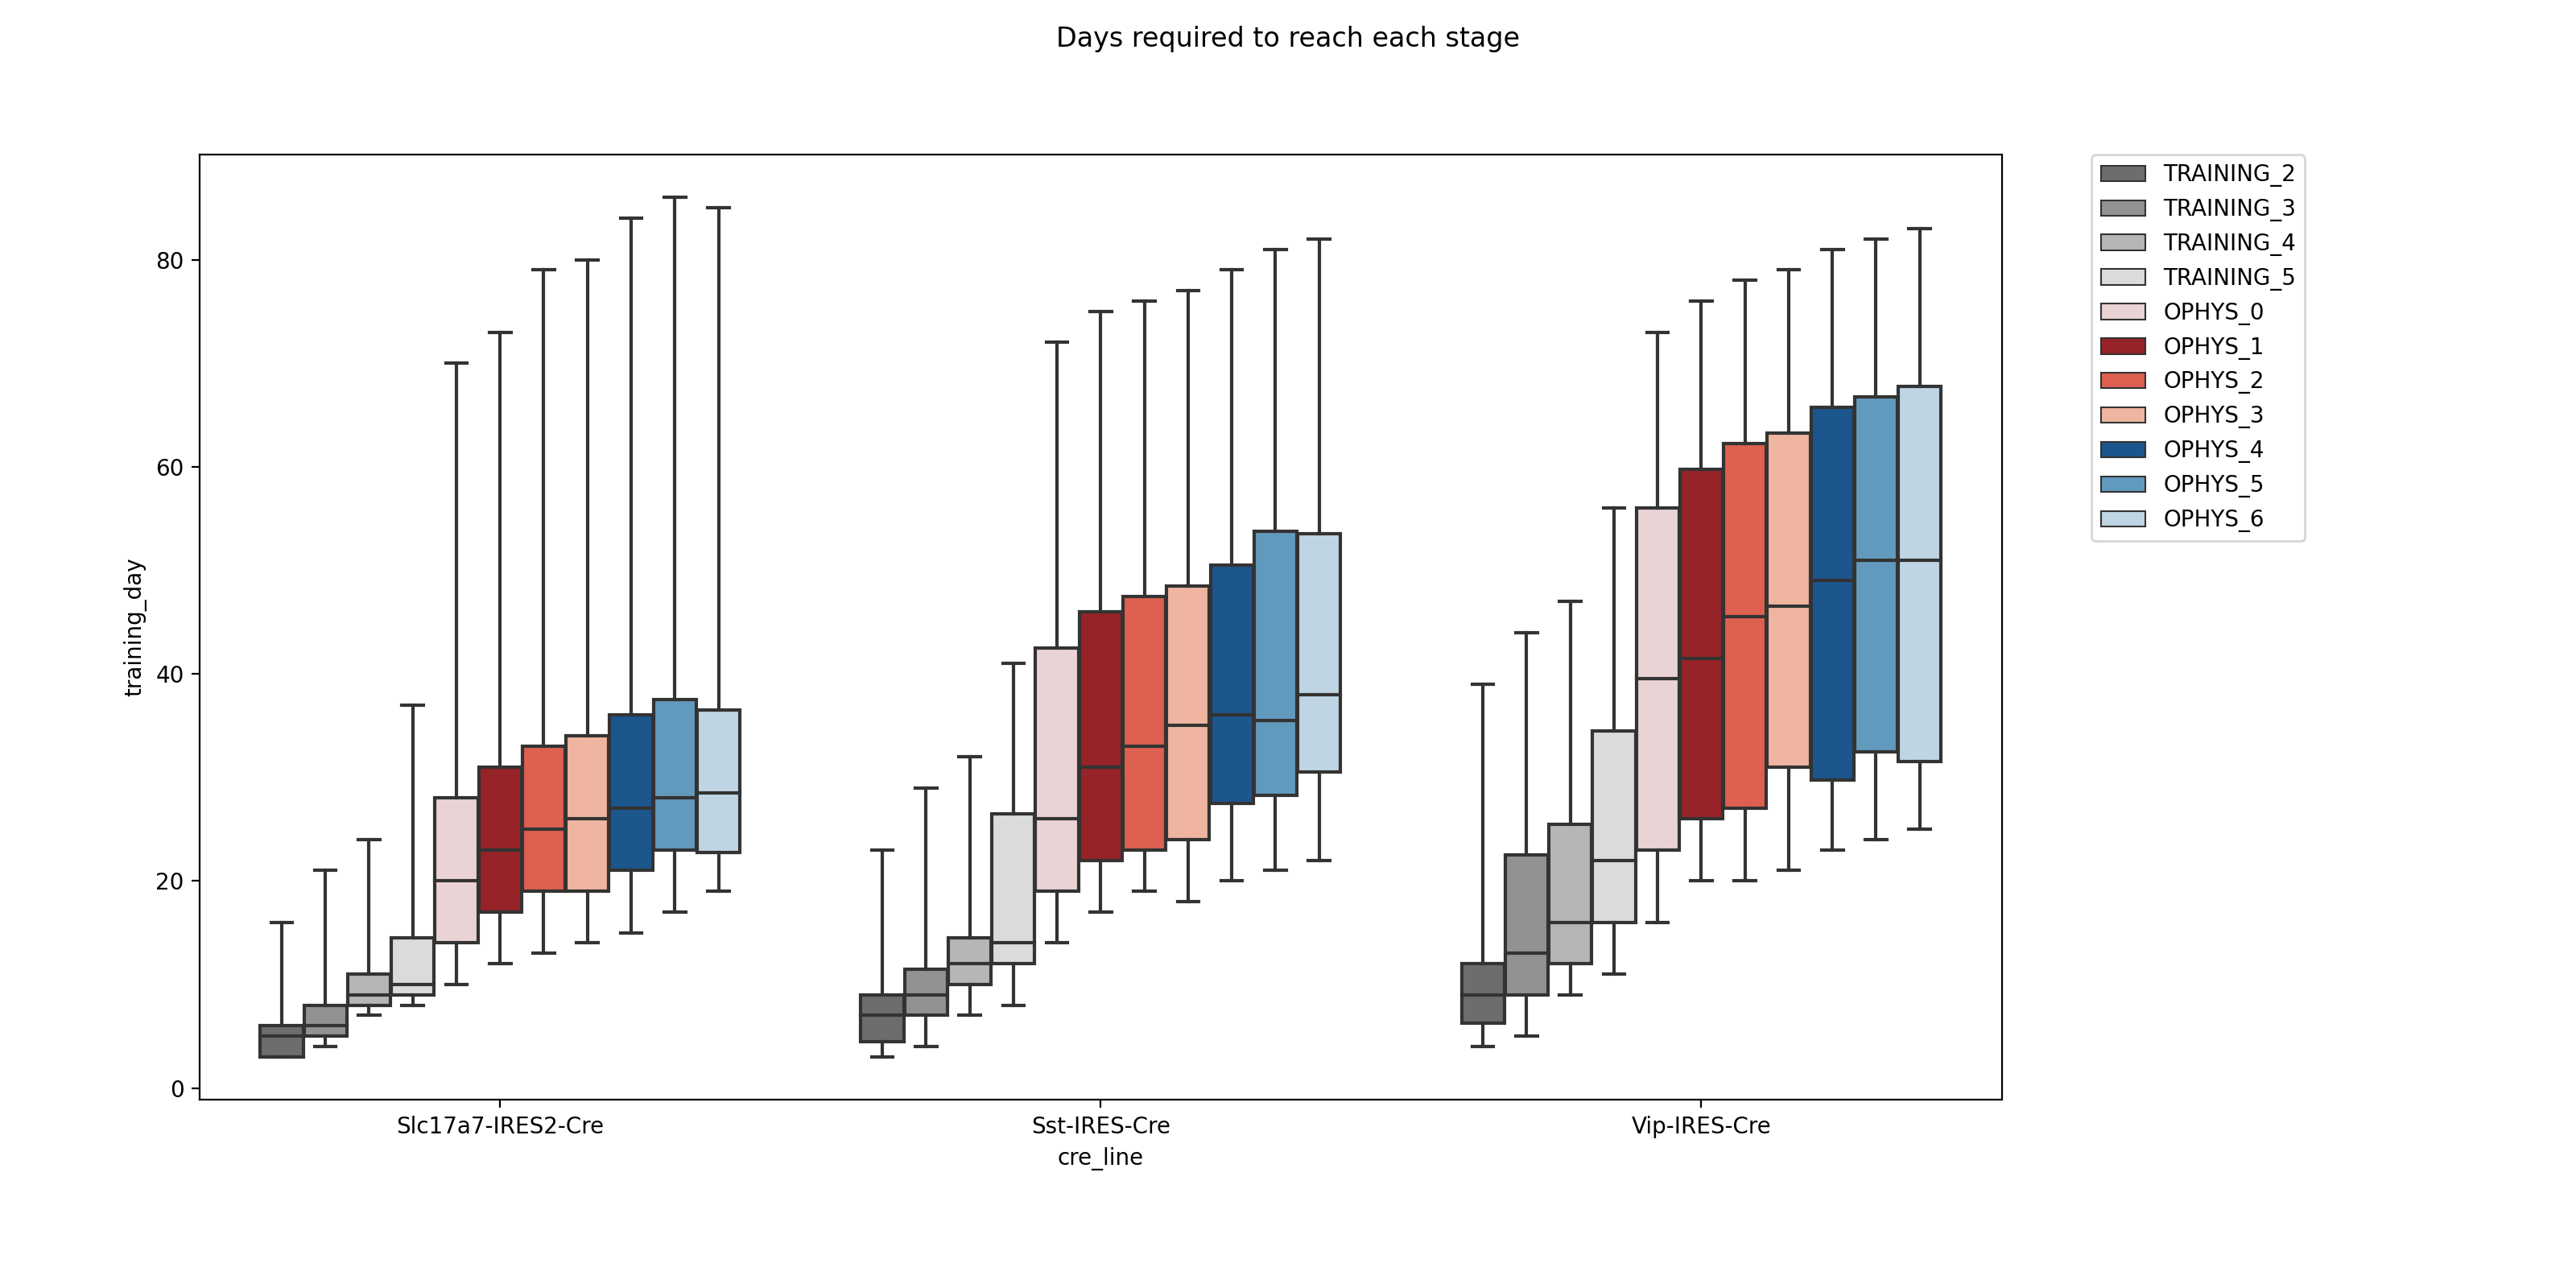

In [16]:
sessions = ['TRAINING_{}'.format(day) for day in range(2,6)] + ['OPHYS_{}'.format(day) for day in range(0, 7)]
data = behavior_session_table.drop_duplicates(subset = ['mouse_id', 'session_type_simple'], keep = 'first').query('session_type_simple in @sessions')

fig, ax = plt.subplots(figsize = (8,4))
sns.boxplot(
    data = data,
    x = 'cre_line',
    y = 'training_day',
    hue = 'session_type_simple',
    hue_order = sessions,
    order = np.sort(data['cre_line'].unique()),
    whis = np.inf,
    palette = palette[2:]
)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.suptitle('Days required to reach each stage')
fig.tight_layout()

<IPython.core.display.Javascript object>


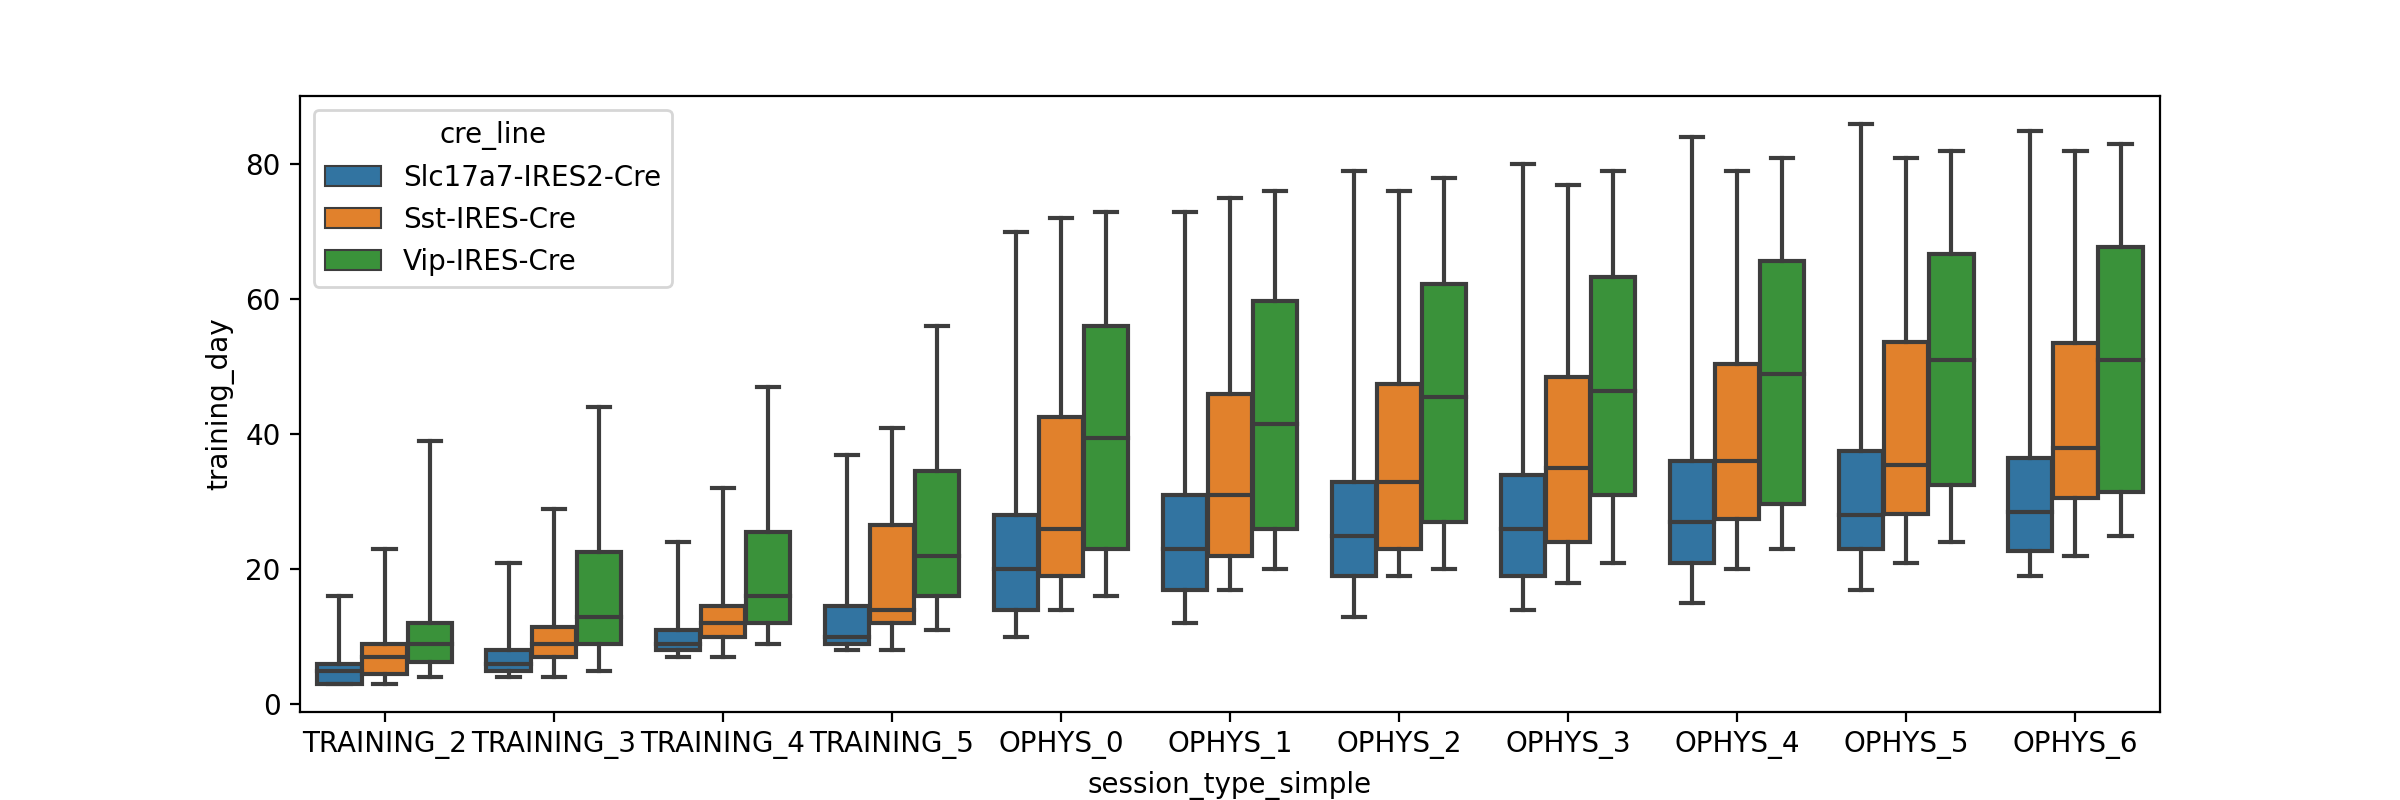

<AxesSubplot:xlabel='session_type_simple', ylabel='training_day'>

In [19]:
sessions = ['TRAINING_{}'.format(day) for day in range(2,6)] + ['OPHYS_{}'.format(day) for day in range(0, 7)]
data = behavior_session_table.drop_duplicates(subset = ['mouse_id', 'session_type_simple'], keep = 'first').query('session_type_simple in @sessions')

fig, ax = plt.subplots(figsize = (12,4))
sns.boxplot(
    data = data,
    x = 'session_type_simple',
    y = 'training_day',
    hue = 'cre_line',
    order = sessions,
    hue_order = np.sort(data['cre_line'].unique()),
    whis = np.inf
)